In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torch.utils.data import Dataset
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Batch Size 
batch_size = 128
image_size = 64
workers = 2

numchannels = 3 #Number of channels 
latent = 100 #Latent Space Size 
gen_feat = 64 # Size of feature maps in generator 
dis_feat = 64 # Size of feature maps in discriminator 

# Number of gpus available. Use 0 for cpu.
num_gpu = 1 

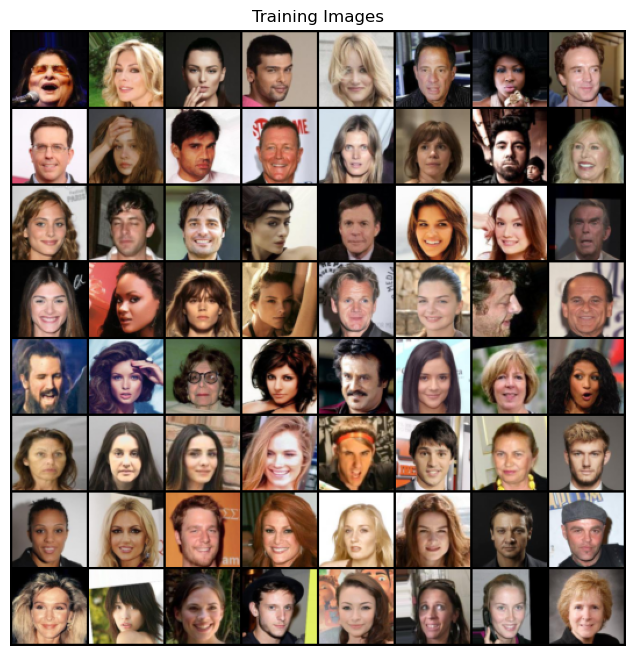

In [3]:
#Impliment data transforms and loading

#TODO
dataroot = '/Users/maryamhakimzadeh/Desktop/Courses-Spring2024/24789/hws/hw2/24789_hw2/img_align_celeba2'  #Add your file path here

transforms = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

dataset = dset.ImageFolder(root=dataroot, transform=transforms)

# Create the dataloader
#TODO
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

#Select device
device = torch.device("cuda:0" if (torch.cuda.is_available() and num_gpu > 0) else "cpu")

#Display real images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [4]:
#Weight initialization for Generator and Discriminator no changes required 
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [5]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, num_gpu):
        super(Generator, self).__init__()
        self.num_gpu = num_gpu
           #Create Generator using ConvTranspose2d
            #TODO
            
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(latent, gen_feat * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(gen_feat * 8),
            nn.ReLU(True),
            # state size. (gen_feat*8) x 4 x 4
            nn.ConvTranspose2d(gen_feat * 8, gen_feat * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(gen_feat * 4),
            nn.ReLU(True),
            # state size. (gen_feat*4) x 8 x 8
            nn.ConvTranspose2d(gen_feat * 4, gen_feat * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(gen_feat * 2),
            nn.ReLU(True),
            # state size. (gen_feat*2) x 16 x 16
            nn.ConvTranspose2d(gen_feat * 2, gen_feat, 4, 2, 1, bias=False),
            nn.BatchNorm2d(gen_feat),
            nn.ReLU(True),
            # state size. (gen_feat) x 32 x 32
            nn.ConvTranspose2d(gen_feat, numchannels, 4, 2, 1, bias=False),
            nn.Tanh()
         
            
#             #One example layer
#             nn.ConvTranspose2d(latent, gen_feat * 8, 4, 1, 0, bias=False),
#             nn.BatchNorm2d(gen_feat * 8),
#             nn.ReLU(True),
        )

    def forward(self, input):
        return self.main(input)

In [6]:
# Create the generator
netG = Generator(num_gpu).to(device)

#Device selection
if (device.type == 'cuda') and (num_gpu > 1):
    netG = nn.DataParallel(netG, list(range(num_gpu)))

netG.apply(weights_init)

print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [7]:
class Discriminator(nn.Module):
    def __init__(self, num_gpu):
        super(Discriminator, self).__init__()
        self.num_gpu = num_gpu
        self.main = nn.Sequential(
            #Create Discriminator using Conv2d
            #TODO
            # Input size: (numchannels) x 64 x 64
            nn.Conv2d(numchannels, dis_feat, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # State size: (dis_feat) x 32 x 32
            nn.Conv2d(dis_feat, dis_feat * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(dis_feat * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # State size: (dis_feat*2) x 16 x 16
            nn.Conv2d(dis_feat * 2, dis_feat * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(dis_feat * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # State size: (dis_feat*4) x 8 x 8
            nn.Conv2d(dis_feat * 4, dis_feat * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(dis_feat * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # State size: (dis_feat*8) x 4 x 4
            nn.Conv2d(dis_feat * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            
            # Output size: 1
#             #One example layer
#             nn.Conv2d(numchannels, dis_feat, 4, 2, 1, bias=False),
#             nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, input):
        return self.main(input)

In [8]:
# Create the Discriminator
netD = Discriminator(num_gpu).to(device)

#Device Selection
if (device.type == 'cuda') and (num_gpu > 1):
    netD = nn.DataParallel(netD, list(range(num_gpu)))

netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [23]:
#Select Loss Function
#TODO

criterion = nn.BCELoss()

fixed_noise = torch.randn(64, latent, 1, 1, device=device)

#Real and fake labels for training
real_label = 1.
fake_label = 0.

# Setup optimizers for Generator and Discriminator 
#TODO
lr = 0.0003
beta1 = 0.5
weight_decay = 0.0001
    
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay = weight_decay)
optimizerG = optim.Adam(netG.parameters(), lr=0.0001, betas=(beta1, 0.999), weight_decay = weight_decay)

In [24]:
# Training Parameters
num_epochs = 1 



# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ## Train with all-real batch
        
        #Train Discriminator
        #TODO 
        
        # Generate fake images 
        #TODO

        #Train Generator
        #TODO
        
        
         # Train with all-real batch
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # Train with all-fake batch
        noise = torch.randn(b_size, latent, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        # Update Generator
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        #Record Losses to Plot
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/1][0/389]	Loss_D: 1.2301	Loss_G: 0.7976	D(x): 0.4674	D(G(z)): 0.2211 / 0.4944
[0/1][50/389]	Loss_D: 0.2946	Loss_G: 4.1657	D(x): 0.9142	D(G(z)): 0.1523 / 0.0343
[0/1][100/389]	Loss_D: 0.2197	Loss_G: 3.8476	D(x): 0.8614	D(G(z)): 0.0162 / 0.0425
[0/1][150/389]	Loss_D: 0.4559	Loss_G: 2.4548	D(x): 0.7357	D(G(z)): 0.0200 / 0.1281
[0/1][200/389]	Loss_D: 0.2637	Loss_G: 2.5412	D(x): 0.8628	D(G(z)): 0.0416 / 0.2022
[0/1][250/389]	Loss_D: 1.6650	Loss_G: 7.8922	D(x): 0.9950	D(G(z)): 0.6785 / 0.0028
[0/1][300/389]	Loss_D: 0.1705	Loss_G: 5.3521	D(x): 0.8832	D(G(z)): 0.0118 / 0.0113
[0/1][350/389]	Loss_D: 0.4897	Loss_G: 2.3022	D(x): 0.7030	D(G(z)): 0.0204 / 0.1700


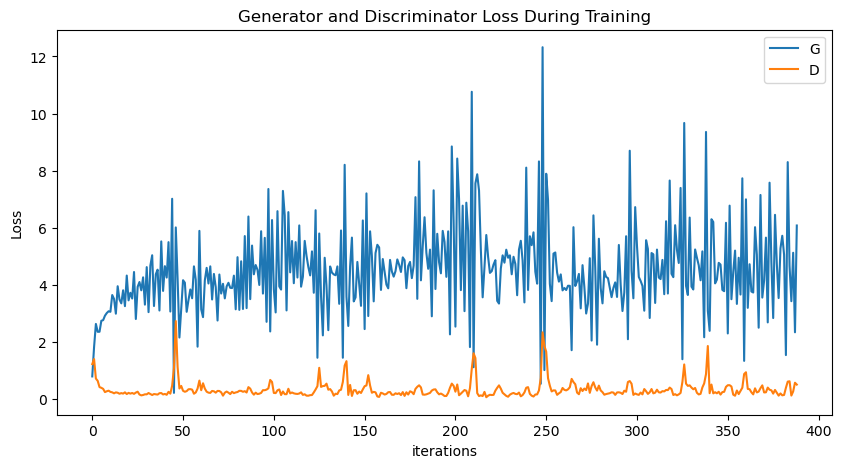

In [25]:
#Plot Your Generator and Discriminator Loss
#No Changes Needed
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

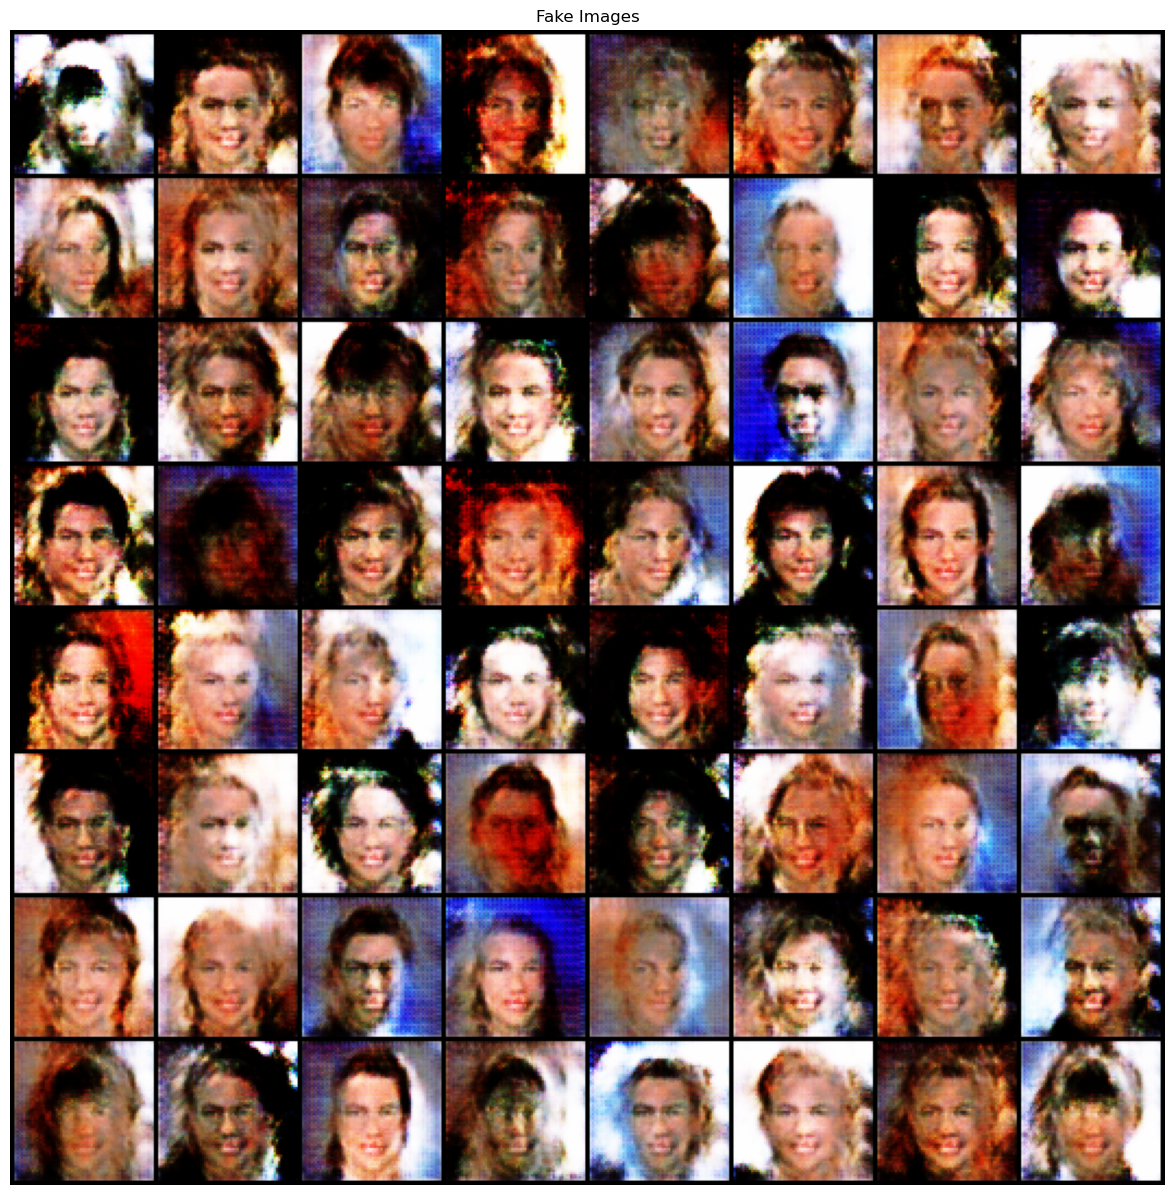

In [26]:
# Fake Images Grid 
#No Changes Needed
plt.figure(figsize=(15,15))
plt.subplot(1,1,1)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()